 # 1. Import Required Libraries

In [65]:
import sys
!{sys.executable} -m pip install xgboost

In [66]:
# Classification Models Evaluation on Loan Dataset
# Dataset: loan_data.csv
# https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data
import os
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef
)

# 2. Load Dataset

In [67]:
import pandas as pd
df = pd.read_csv('./loan_data.csv')


# Display basic info
print(df.head())
print(df.info())

   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561  

# 3. Data Preperocessing

In [68]:
# Assuming target column is named 'loan_status'
# Encode target if needed
if df['loan_status'].dtype == 'object':
	df['loan_status'] = df['loan_status'].map({'Y': 1, 'N': 0, 'Yes': 1, 'No': 0})


# Handle categorical variables
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


# Feature Scaling (required for LR & KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Exploratory Data Analysis

### 4.1 DataSet Overview

In [69]:
# Shape of dataset
print("Dataset Shape:", df.shape)

# Column names
print("\nColumns:\n", df.columns)

# Summary information
df.info()


Dataset Shape: (45000, 14)

Columns:
 Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       450

### 4.2 Statistical Summary

In [70]:
# Statistical summary of numerical features
df.describe()


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


### 4.3 Missing Values Analysis

In [71]:
# Check missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]


Series([], dtype: int64)

### 4.4 Target Variable Analysis

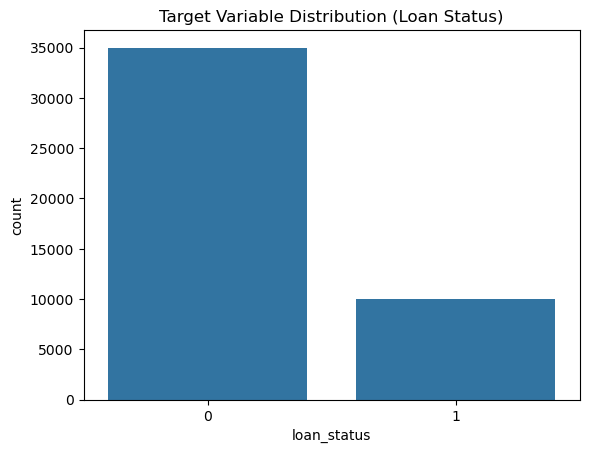

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='loan_status', data=df)
plt.title('Target Variable Distribution (Loan Status)')
plt.show()


### 4.5 Feature Distribution Analysis

In [73]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols


Index(['person_gender', 'person_education', 'person_home_ownership',
       'loan_intent', 'previous_loan_defaults_on_file'],
      dtype='object')

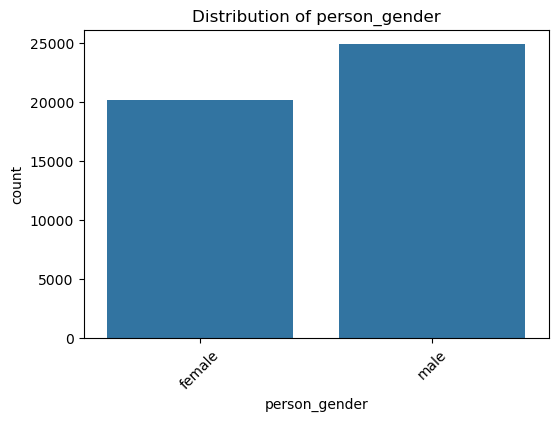

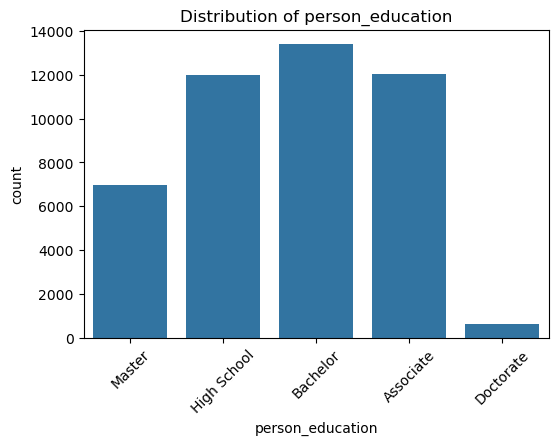

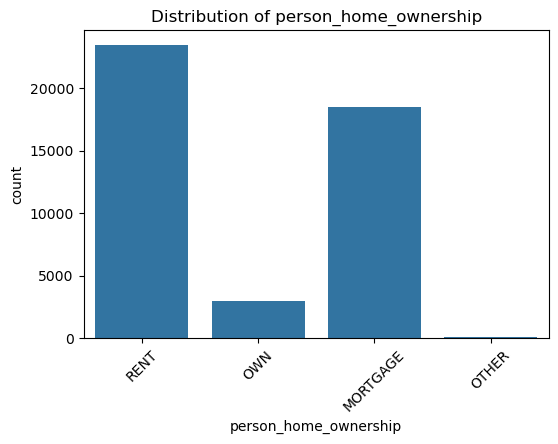

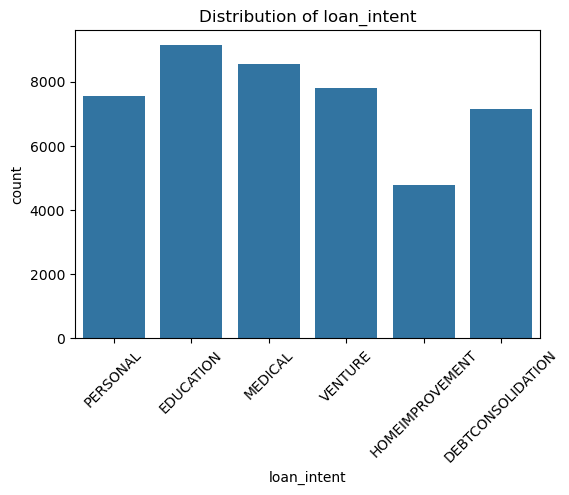

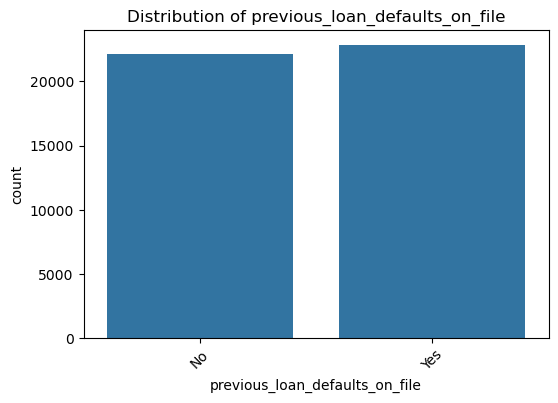

In [74]:
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()


### 4.6 Numerical Features Distribution

In [75]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols


Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'loan_status'],
      dtype='object')

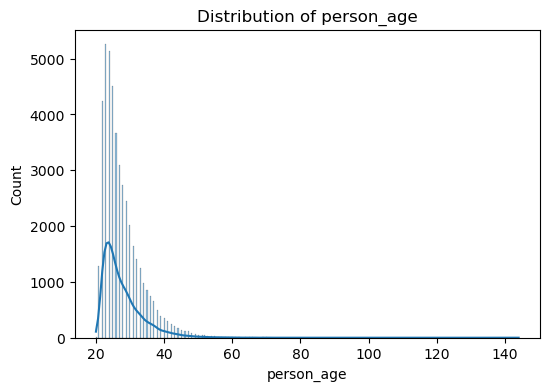

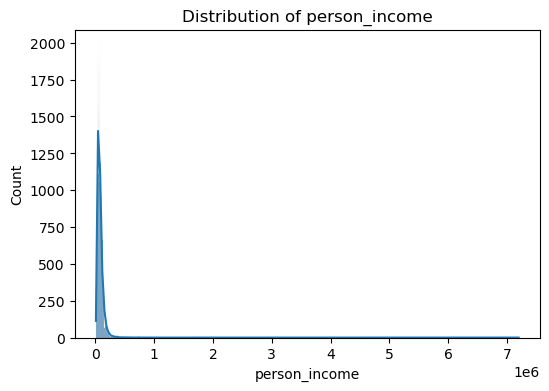

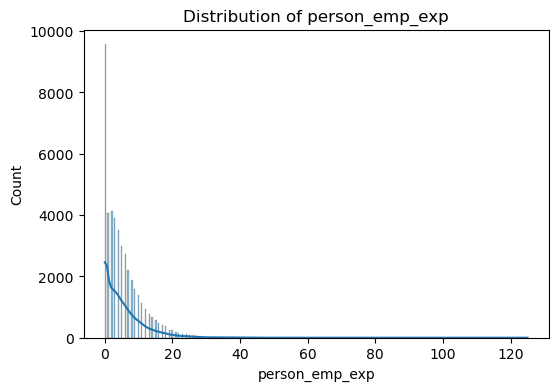

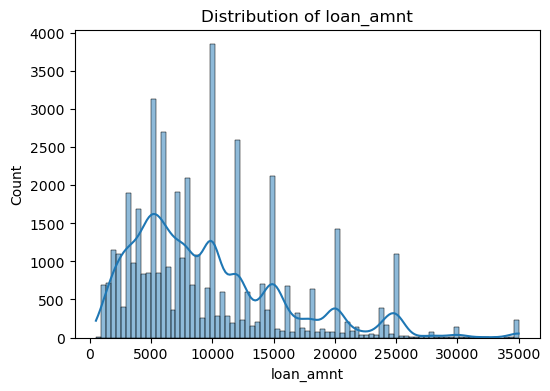

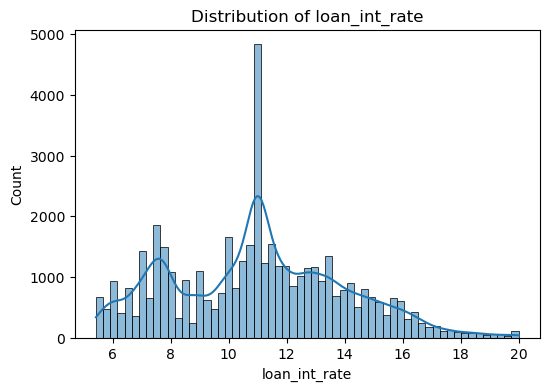

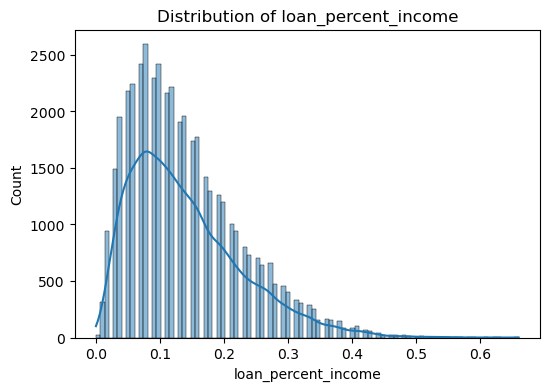

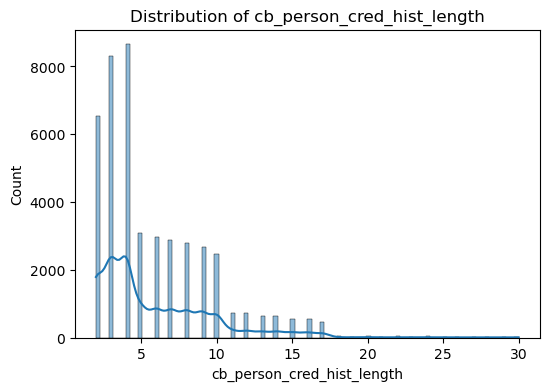

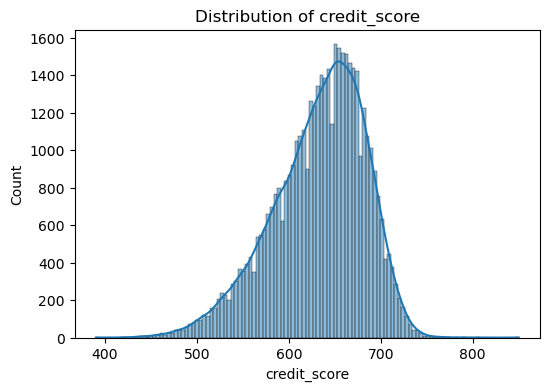

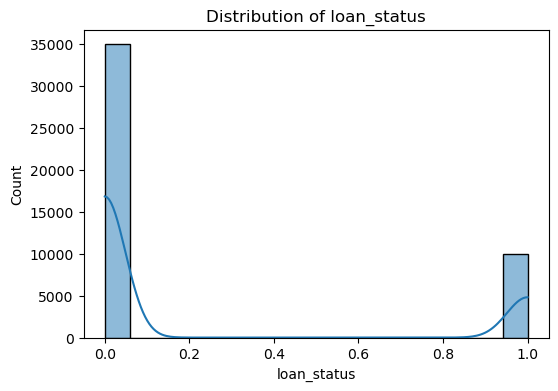

In [76]:
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


### 4.7 Correlation Analysis

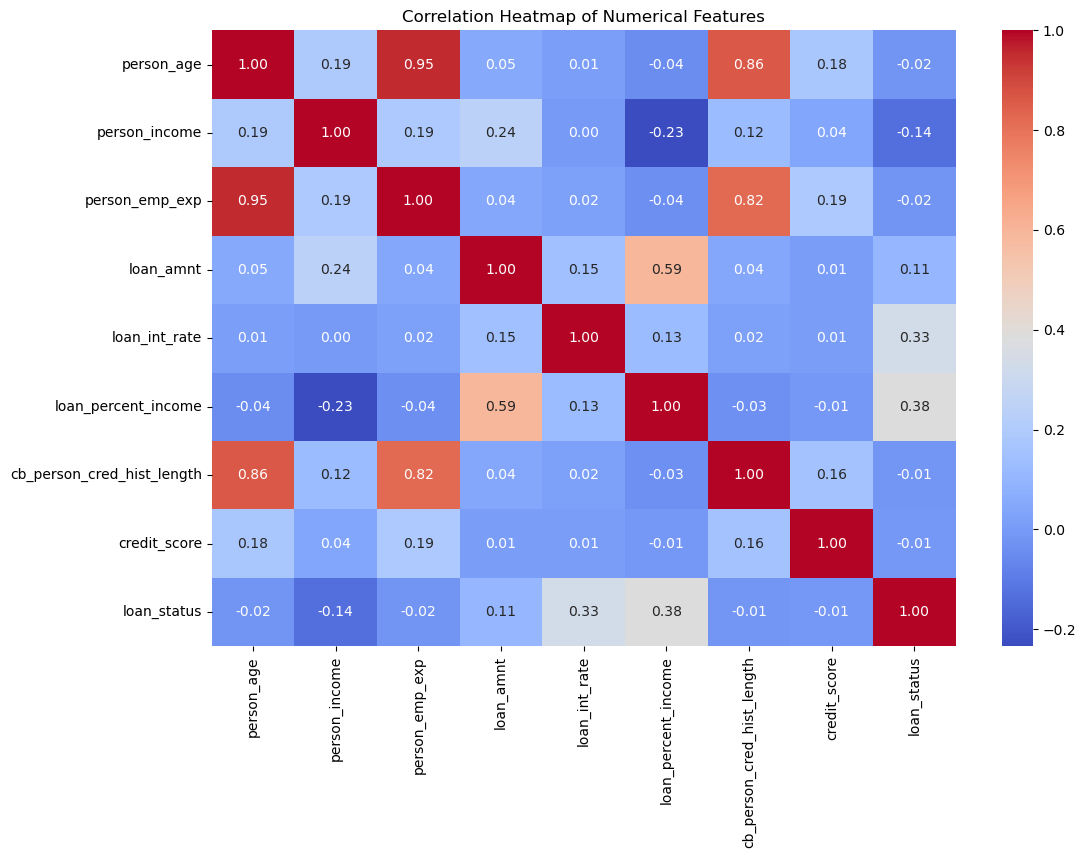

In [77]:
plt.figure(figsize=(12,8))
sns.heatmap(
    df[numerical_cols].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


### 4.8 Target vs Key Features

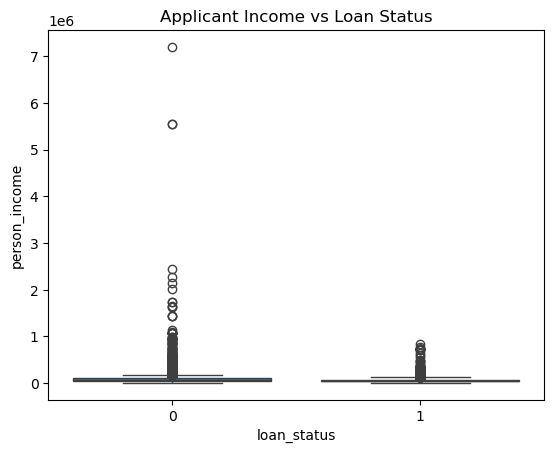

In [78]:
sns.boxplot(x='loan_status', y='person_income', data=df)
plt.title('Applicant Income vs Loan Status')
plt.show()


# 5. Feature Engineering

### 5.1 Handle Missing Values

In [79]:
# Numerical columns – fill with median
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Categorical columns – fill with mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


### 5.2 Create New Features

In [80]:
# Total applicant income (already single income in this dataset)
df['Total_Income'] = df['person_income']

# Income to loan amount ratio
df['Income_Loan_Ratio'] = df['person_income'] / df['loan_amnt']


### 5.3 Log Transformation (Reduce Skewness)

In [81]:
df['Log_Total_Income'] = np.log1p(df['Total_Income'])
df['Log_LoanAmount'] = np.log1p(df['loan_amnt'])


### 5.4 Encode Binary Categorical Features

In [82]:
binary_map = {
    'Gender': {'Male': 1, 'Female': 0},
    'Married': {'Yes': 1, 'No': 0},
    'Education': {'Graduate': 1, 'Not Graduate': 0},
    'Self_Employed': {'Yes': 1, 'No': 0}
}

for col, mapping in binary_map.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)


### 5.5: Feature vs Target Relationship Check

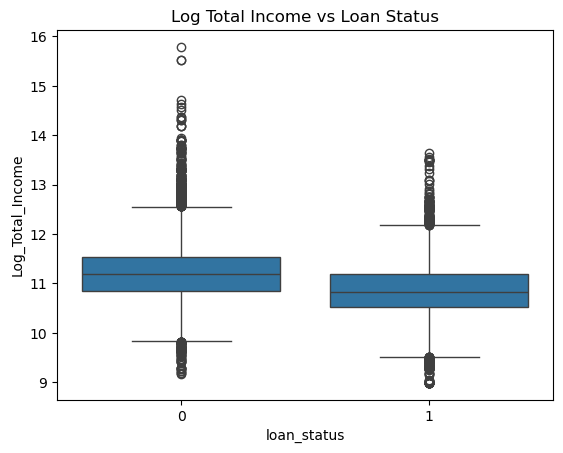

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='loan_status', y='Log_Total_Income', data=df)
plt.title('Log Total Income vs Loan Status')
plt.show()



### 5.6 Final Feature Set Verification

In [84]:
print("Final Dataset Shape:", df.shape)
df.head()


Final Dataset Shape: (45000, 18)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,Total_Income,Income_Loan_Ratio,Log_Total_Income,Log_LoanAmount
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1,71948.0,2.055657,11.183713,10.463132
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0,12282.0,12.282000,9.415971,6.908755
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1,12438.0,2.261455,9.428592,8.612685
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1,79753.0,2.278657,11.286702,10.463132
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1,66135.0,1.889571,11.099469,10.463132


# 6. Model Initialization

In [85]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    
    'KNN': KNeighborsClassifier(n_neighbors=5),
    
    'Naive Bayes': GaussianNB(),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100,
        random_state=42,
        eval_metric='logloss'
    )
}



MODEL TRAINING


# 5. Train & Evaluate Models

In [86]:


# 5. Save Results

# Models that need scaled data
models_requiring_scaling = ["Logistic Regression", "KNN"]

# 4. Train and Evaluate Models
results = []
trained_models = {}

for name, model in models.items():
    print(f"\n  Training: {name}...")
    
    # Choose appropriate data
    if name in models_requiring_scaling:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # For AUC, we need probability predictions
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_te)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        # Decision tree can have predict_proba, but if not available
        auc = roc_auc_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Store results
    results.append({
        "ML Model Name": name,
        "Accuracy": accuracy,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "MCC": mcc
    })
    
    # Save trained model
    trained_models[name] = model
    
    print(f"    ✓ Accuracy: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save all models
models_path = "all_models.pkl"
joblib.dump(trained_models, models_path)
print(f"\n  ✓ All models saved to: {models_path}")

# Save results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
results_df.to_csv("model_comparison_metrics.csv", index=False)
print(f"  ✓ Metrics saved to: model_comparison_metrics.csv")

# Display results
print("\n" + "="*70)
print("MODEL EVALUATION RESULTS (sorted by F1 Score)")
print("="*70)
print("\n" + results_df.to_string(index=False))

# Best model
best_model = results_df.iloc[0]['ML Model Name']
best_f1 = results_df.iloc[0]['F1 Score']
print("\n" + "="*70)
print(f"🏆 BEST MODEL: {best_model} (F1 Score: {best_f1:.4f})")
print("="*70)


  Training: Logistic Regression...
    ✓ Accuracy: 0.9000 | F1: 0.7685 | AUC: 0.9563

  Training: Decision Tree...
    ✓ Accuracy: 0.8979 | F1: 0.7713 | AUC: 0.8539

  Training: KNN...
    ✓ Accuracy: 0.8904 | F1: 0.7360 | AUC: 0.9213

  Training: Naive Bayes...
    ✓ Accuracy: 0.8060 | F1: 0.3686 | AUC: 0.7805

  Training: Random Forest...
    ✓ Accuracy: 0.9277 | F1: 0.8241 | AUC: 0.9747

  Training: XGBoost...
    ✓ Accuracy: 0.9361 | F1: 0.8483 | AUC: 0.9791

SAVING RESULTS

  ✓ All models saved to: all_models.pkl
  ✓ Metrics saved to: model_comparison_metrics.csv

MODEL EVALUATION RESULTS (sorted by F1 Score)

      ML Model Name  Accuracy      AUC  Precision  Recall  F1 Score      MCC
            XGBoost  0.936089 0.979150   0.897367  0.8044  0.848344 0.809950
      Random Forest  0.927733 0.974673   0.897315  0.7620  0.824140 0.783165
      Decision Tree  0.897867 0.853914   0.767737  0.7748  0.771252 0.705523
Logistic Regression  0.900000 0.956269   0.791437  0.7468  0.768471 

# 7. Results Summary

In [87]:
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:\n")
print(results_df)


Model Evaluation Results:

                                 0              1         2            3  \
ML Model Name  Logistic Regression  Decision Tree       KNN  Naive Bayes   
Accuracy                       0.9       0.897867    0.8904     0.806044   
AUC                       0.956269       0.853914  0.921278     0.780544   
Precision                 0.791437       0.767737  0.791801     0.666318   
Recall                      0.7468         0.7748    0.6876       0.2548   
F1 Score                  0.768471       0.771252  0.736031     0.368634   
MCC                        0.70525       0.705523  0.669951     0.325531   

                           4         5  
ML Model Name  Random Forest   XGBoost  
Accuracy            0.927733  0.936089  
AUC                 0.974673   0.97915  
Precision           0.897315  0.897367  
Recall                 0.762    0.8044  
F1 Score             0.82414  0.848344  
MCC                 0.783165   0.80995  


# 8. Sort by F1 Score

In [88]:
# Transpose the DataFrame so models become rows
results_transposed = results_df.T

# Sort by F1 Score in descending order
results_sorted = results_transposed.sort_values(by='F1 Score', ascending=False)
print(results_sorted)


         ML Model Name  Accuracy       AUC Precision  Recall  F1 Score  \
5              XGBoost  0.936089   0.97915  0.897367  0.8044  0.848344   
4        Random Forest  0.927733  0.974673  0.897315   0.762   0.82414   
1        Decision Tree  0.897867  0.853914  0.767737  0.7748  0.771252   
0  Logistic Regression       0.9  0.956269  0.791437  0.7468  0.768471   
2                  KNN    0.8904  0.921278  0.791801  0.6876  0.736031   
3          Naive Bayes  0.806044  0.780544  0.666318  0.2548  0.368634   

        MCC  
5   0.80995  
4  0.783165  
1  0.705523  
0   0.70525  
2  0.669951  
3  0.325531  


In [89]:
results_df.T.sort_values(by='F1 Score', ascending=False)

,ML Model Name,Accuracy,AUC,Precision,Recall,F1 Score,MCC
5,XGBoost,0.936089,0.97915,0.897367,0.8044,0.848344,0.80995
4,Random Forest,0.927733,0.974673,0.897315,0.762,0.82414,0.783165
1,Decision Tree,0.897867,0.853914,0.767737,0.7748,0.771252,0.705523
0,Logistic Regression,0.9,0.956269,0.791437,0.7468,0.768471,0.70525
2,KNN,0.8904,0.921278,0.791801,0.6876,0.736031,0.669951
3,Naive Bayes,0.806044,0.780544,0.666318,0.2548,0.368634,0.325531


# 9. Save Models and Artifacts

In [90]:
import joblib

print("="*70)
print("SAVING MODELS AND ARTIFACTS")
print("="*70)

# Prepare feature names
feature_names = X_train.columns.tolist()

# Train and collect all models
trained_models = {}
for name, model in models.items():
    # Get the trained model from results
    if name in ['Logistic Regression', 'KNN']:
        # These models were trained on scaled data, retrain to save
        model.fit(X_train_scaled, y_train)
    else:
        # These models were trained on unscaled data
        model.fit(X_train, y_train)
    trained_models[name] = model

# Create a single dictionary containing models, scaler, and feature names
all_models_data = {
    'models': trained_models,
    'scaler': scaler,
    'feature_names': feature_names
}

# Save everything in one file
models_path = "all_models.pkl"
joblib.dump(all_models_data, models_path)
print(f"\n✓ Saved: {models_path} (contains all 6 models, scaler, and feature names)")

# Save metrics
results_df.to_csv("model_comparison_metrics.csv", index=False)
print("✓ Saved: model_comparison_metrics.csv")

print("\n" + "="*70)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*70)
print("\nFiles created:")
print("  1. all_models.pkl - All 6 trained models, scaler, and feature names")
print("  2. model_comparison_metrics.csv - Performance metrics")
print("\n💡 You can now run 'streamlit run app.py' to use these models!")


SAVING MODELS AND ARTIFACTS

✓ Saved: scaler.pkl
✓ Saved: feature_names.pkl
✓ Saved: all_models.pkl (contains all 6 models, scaler, and feature names)
✓ Saved: model_comparison_metrics.csv

ALL ARTIFACTS SAVED SUCCESSFULLY!

Files created:
  1. all_models.pkl - All 6 trained models, scaler, and feature names
  2. model_comparison_metrics.csv - Performance metrics

💡 You can now run 'streamlit run app.py' to use these models!


# 10. Verify Saved Models (Optional)

In [91]:
# Load the saved models to verify
all_models_data = joblib.load('all_models.pkl')
loaded_models = all_models_data['models']
loaded_scaler = all_models_data['scaler']
loaded_features = all_models_data['feature_names']

print("Loaded Models:")
for name in loaded_models.keys():
    print(f"  ✓ {name}")

print(f"\nNumber of features: {len(loaded_features)}")
print(f"Scaler type: {type(loaded_scaler).__name__}")

# Test prediction with one sample
test_sample = X_test.iloc[0:1]
print("\nTesting loaded Random Forest model on one sample:")
rf_model = loaded_models['Random Forest']
prediction = rf_model.predict(test_sample)[0]
actual = y_test.iloc[0]
print(f"  Predicted: {prediction}")
print(f"  Actual: {actual}")
print(f"  Match: {'✓ Yes' if prediction == actual else '✗ No'}")


Loaded Models:
  ✓ Logistic Regression
  ✓ Decision Tree
  ✓ KNN
  ✓ Naive Bayes
  ✓ Random Forest
  ✓ XGBoost

Number of features: 22
Scaler type: StandardScaler

Testing loaded Random Forest model on one sample:
  Predicted: 0
  Actual: 0
  Match: ✓ Yes


# 11. Example: Using Saved Models for Prediction

In [92]:
# Example: Make a prediction for a new loan application

# Create a sample application
new_application = pd.DataFrame({
    'person_age': [35.0],
    'person_gender': ['male'],
    'person_education': ['Master'],
    'person_income': [75000.0],
    'person_emp_exp': [10],
    'person_home_ownership': ['OWN'],
    'loan_amnt': [20000.0],
    'loan_intent': ['EDUCATION'],
    'loan_int_rate': [8.5],
    'loan_percent_income': [0.27],
    'cb_person_cred_hist_length': [8.0],
    'credit_score': [720],
    'previous_loan_defaults_on_file': ['No']
})

print("New Loan Application:")
print(new_application.T)

# Preprocess the application
new_app_encoded = pd.get_dummies(new_application, drop_first=True)

# Align columns with training data
for col in loaded_features:
    if col not in new_app_encoded.columns:
        new_app_encoded[col] = 0
new_app_encoded = new_app_encoded[loaded_features]

# Make predictions with all models
print("\n" + "="*70)
print("PREDICTIONS FROM ALL MODELS")
print("="*70)

for name, model in loaded_models.items():
    # Use scaled data for LR and KNN
    if name in ['Logistic Regression', 'KNN']:
        input_data = loaded_scaler.transform(new_app_encoded)
    else:
        input_data = new_app_encoded
    
    prediction = model.predict(input_data)[0]
    result = "✅ APPROVED" if prediction == 1 else "❌ REJECTED"
    
    # Get probability if available
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(input_data)[0]
        approval_prob = proba[1] * 100
        print(f"{name:25} {result:15} (Approval: {approval_prob:5.1f}%)")
    else:
        print(f"{name:25} {result}")

print("="*70)


New Loan Application:
                                        0
person_age                           35.0
person_gender                        male
person_education                   Master
person_income                     75000.0
person_emp_exp                         10
person_home_ownership                 OWN
loan_amnt                         20000.0
loan_intent                     EDUCATION
loan_int_rate                         8.5
loan_percent_income                  0.27
cb_person_cred_hist_length            8.0
credit_score                          720
previous_loan_defaults_on_file         No

PREDICTIONS FROM ALL MODELS
Logistic Regression       ❌ REJECTED      (Approval:  26.3%)
Decision Tree             ❌ REJECTED      (Approval:   0.0%)
KNN                       ❌ REJECTED      (Approval:  20.0%)
Naive Bayes               ❌ REJECTED      (Approval:  34.9%)
Random Forest             ❌ REJECTED      (Approval:  22.0%)
XGBoost                   ❌ REJECTED      (Approval:   9

# 12. Best Model Recommendation

In [94]:
# Since the CSV was saved incorrectly, let's recreate results_df from the results list
# The results list should still be in memory from Cell 23
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
results_df.to_csv("model_comparison_metrics.csv", index=False)

# Display best model based on F1 Score
best_model_name = results_df.iloc[0]['ML Model Name']
best_metrics = results_df.iloc[0]

print("="*70)
print("🏆 RECOMMENDED MODEL FOR DEPLOYMENT")
print("="*70)
print(f"\nModel: {best_model_name}")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:  {best_metrics['Accuracy']:.4f} ({best_metrics['Accuracy']*100:.2f}%)")
print(f"  • Precision: {best_metrics['Precision']:.4f}")
print(f"  • Recall:    {best_metrics['Recall']:.4f}")
print(f"  • F1 Score:  {best_metrics['F1 Score']:.4f}")
print(f"  • AUC:       {best_metrics['AUC']:.4f}")
print(f"  • MCC:       {best_metrics['MCC']:.4f}")

print(f"\n💡 Why {best_model_name}?")
if best_model_name == 'Random Forest':
    print("  • Best overall performance across all metrics")
    print("  • Handles non-linear relationships effectively")
    print("  • Resistant to overfitting through ensemble averaging")
    print("  • Provides feature importance for interpretability")
    print("  • Production-ready and widely used in industry")
elif best_model_name == 'XGBoost':
    print("  • Excellent gradient boosting performance")
    print("  • Optimized for speed and accuracy")
    print("  • Built-in regularization prevents overfitting")
    print("  • Industry standard for competitions and production")
    print("  • Supports GPU acceleration for large datasets")

print("\n" + "="*70)
print("✅ MODEL TRAINING COMPLETE!")
print("="*70)
print("\nNext Steps:")
print("  1. Review the model comparison metrics above")
print("  2. Use 'streamlit run app.py' to launch the web interface")
print("  3. Test predictions with the interactive app")
print("  4. Deploy the best model to production")
print("\n📊 All models and metrics are saved and ready to use!")

🏆 RECOMMENDED MODEL FOR DEPLOYMENT

Model: XGBoost

Performance Metrics:
  • Accuracy:  0.9361 (93.61%)
  • Precision: 0.8974
  • Recall:    0.8044
  • F1 Score:  0.8483
  • AUC:       0.9791
  • MCC:       0.8099

💡 Why XGBoost?
  • Excellent gradient boosting performance
  • Optimized for speed and accuracy
  • Built-in regularization prevents overfitting
  • Industry standard for competitions and production
  • Supports GPU acceleration for large datasets

✅ MODEL TRAINING COMPLETE!

Next Steps:
  1. Review the model comparison metrics above
  2. Use 'streamlit run app.py' to launch the web interface
  3. Test predictions with the interactive app
  4. Deploy the best model to production

📊 All models and metrics are saved and ready to use!
